In [41]:
import numpy as np

from astropy.io import fits

import matplotlib.pyplot as plt
import glob

from scipy.optimize import curve_fit
from photutils import datasets
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from photutils import DAOStarFinder

from astropy.stats import mad_std
import ccdproc
from ccdproc import subtract_overscan

from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS

from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)

from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)


Removing Bias, Overscan, and Flats
=============================

## Bias

In [3]:
#Getting all biases for 2019-05-03
bias1 = fits.getdata('/astro/users/lexie98/Documents/Bias1.fits').astype(np.int32)
bias2 = fits.getdata('/astro/users/lexie98/Documents/Bias2.fits').astype(np.int32)
bias3 = fits.getdata('/astro/users/lexie98/Documents/Bias3.fits').astype(np.int32)
bias4 = fits.getdata('/astro/users/lexie98/Documents/Bias4.fits').astype(np.int32)
bias5 = fits.getdata('/astro/users/lexie98/Documents/Bias5.fits').astype(np.int32)
bias6 = fits.getdata('/astro/users/lexie98/Documents/Bias6.fits').astype(np.int32)

In [4]:
#Making a master bias
master_bias = (np.mean(bias1) + np.mean(bias2) + np.mean(bias3) + np.mean(bias4) 
                + np.mean(bias5) + np.mean(bias6)) / 6
master_bias

1310.8948334058125

In [5]:
#Getting fits files of M82
m82_list = glob.glob('/astro/users/lexie98/Documents/m82*.fits')
#Index fliters: 0-halpha 1-g 2-i 3-r 4-r 5-u 6-z

m82_values = []
m82_no_bias = []

#getting data for each fits file
for filename in m82_list:
    # Open the FITS file
    hdu = fits.open(filename)
    
    values = hdu[0].data 
    m82_values.append(values)
    
    bias_remove = values - master_bias
    m82_no_bias.append(bias_remove)



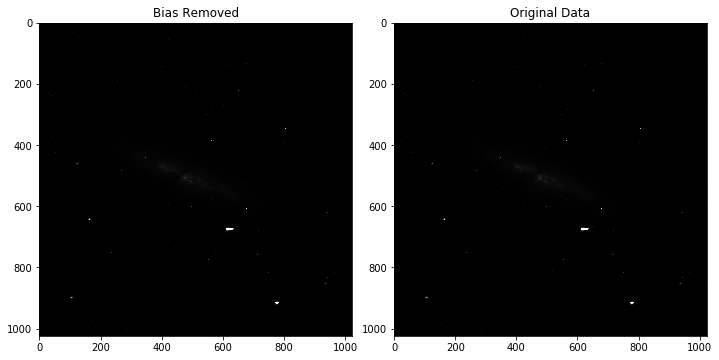

In [6]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(10,6)

fig.tight_layout()
ax[0].set_title("Bias Removed")
ax[1].set_title("Original Data")

ax[0].imshow(m82_no_bias[4],cmap=plt.cm.gray)
ax[1].imshow(m82_values[4], cmap=plt.cm.gray);

## Overscan
##### Attempting to remove overscan . . . doesn't go well

CCDData([[635, 604, 610, ..., 566, 540, 546],
         [607, 591, 603, ..., 510, 518, 530],
         [613, 619, 626, ..., 534, 540, 524],
         ...,
         [642, 642, 641, ..., 564, 568, 545],
         [632, 643, 631, ..., 548, 556, 576],
         [618, 637, 644, ..., 546, 576, 569]])

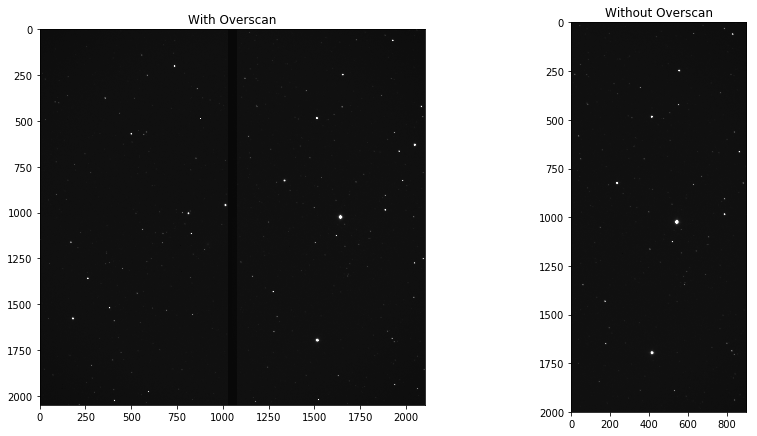

In [7]:
#Getting images with overscan
wolfimages = glob.glob('/astro/users/lexie98/Documents/wolf*.fits')

wolf_values = []

for filename in wolfimages:
    # Open the FITS file
    hdu = fits.open(filename)
    
    values = hdu[0].data 
    wolf_values.append(values)

#Trimming overscan
ccd = ccdproc.CCDData(wolf_values[0], unit="electron")
trimmed = ccdproc.trim_image(ccd,fits_section='[1:1000, 1:2000]')
trimmed2 = ccdproc.trim_image(ccd,fits_section='[1100:2000, 1:2000]')


#Plotting overscan image and no-overscan image
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

fig.tight_layout()
ax[0].set_title("With Overscan")
ax[1].set_title("Without Overscan")

ax[0].imshow(wolf_values[0],cmap=plt.cm.gray, vmin = 0, vmax= 10000)
ax[1].imshow(trimmed2, cmap=plt.cm.gray, vmin = 0, vmax = 10000);

trimmed2

## Flat Reduction

In [9]:
#Grabbing flats for each filter
domeflats_g = glob.glob('/astro/users/lexie98/Documents/domeflat_sdss_g*.fits')
domeflats_i = glob.glob('/astro/users/lexie98/Documents/domeflat_sdss_i*.fits')
domeflats_r = glob.glob('/astro/users/lexie98/Documents/domeflat_sdss_r*.fits')
domeflats_z = glob.glob('/astro/users/lexie98/Documents/domeflat_sdss_z*.fits')

g = fits.open(domeflats_g[1])


In [10]:
def flat_remove(flats, image):
    flats_values = []
    for filename in flats:
        # Open the FITS file
        hdu = fits.open(filename)
    
        values = hdu[0].data
        flats_values.append(values)
    
    mean_flat = np.mean(flats_values, axis=0)
    fits_no_flat = image / np.mean(flats_values, axis=0)
    return(fits_no_flat, mean_flat)

In [11]:

r_flatcorrected, mean_flat = flat_remove(domeflats_r, m82_no_bias[0])

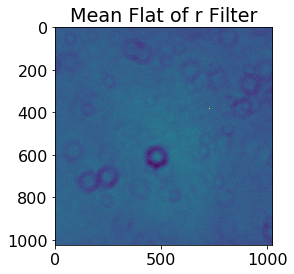

In [24]:
plt.title('Mean Flat of r Filter')
plt.imshow(mean_flat);

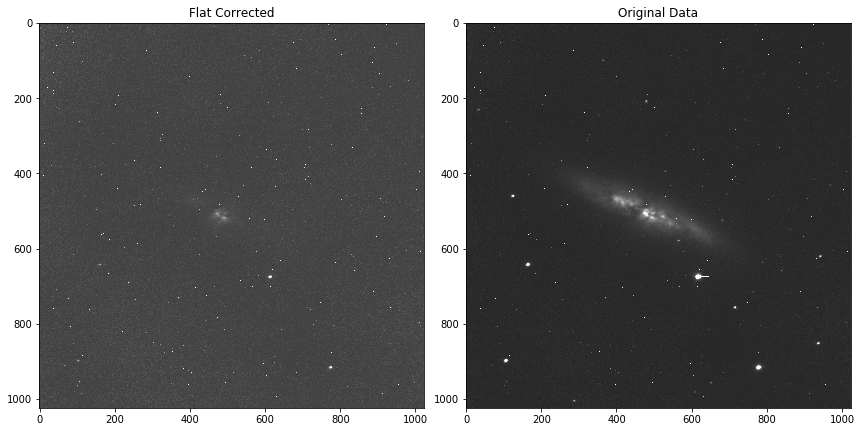

In [14]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)


fig.tight_layout()
ax[0].set_title("Flat Corrected")
ax[1].set_title("Original Data")

ax[0].imshow(r_flatcorrected.data,cmap=plt.cm.gray, vmin=-0.1, vmax=0.3)
ax[1].imshow(m82_values[4], cmap=plt.cm.gray, vmin=0, vmax=10000);

Photometry
==========

### Appertures 

In [15]:
hdu = fits.open('/astro/users/lexie98/Documents/Photometry/quadRU.fits')     
image = hdu[0].data   
image -= np.median(image)


In [29]:
#Finding stars
bkg_sigma = mad_std(image)    
daofind = DAOStarFinder(fwhm=4., threshold=8.*bkg_sigma)    
sources = daofind(image)    

#Removing the sources near the border
maskx1 = np.where(sources['xcentroid']>20)
sources2 = sources[maskx1]
maskx2 = np.where(sources2['xcentroid']<1000)
sources3 = sources2[maskx2]
masky1 = np.where(sources3['ycentroid']>20)
sources4 = sources3[masky1]
masky2 = np.where(sources4['ycentroid']<1000)
sources = sources4[masky2]
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
4,172.86662561407712,24.843851416988482,0.3960206897690091,0.29502123447718587,-0.1514336360987952,25,0.0,3606.419236423088,15.82154327262789,-2.9981221084757497
5,587.5937806506138,36.75153696032994,0.43103539345740394,0.25811493651708817,-0.2186904971141848,25,0.0,1893.5643173199064,7.537894460518223,-2.1931251312930424
6,550.5956282416972,40.522206397186935,0.461776935881787,0.25601767013495536,-0.10648802610839735,25,0.0,488.52975299707737,1.87846454956949,-0.684507508650722
8,306.8402462567255,53.96426698034937,0.42562333267334945,0.13938004192119485,-0.21341924811041205,25,0.0,369.05408909062567,1.5683118792606459,-0.48858108013967316
9,288.2562703963834,58.44526849941758,0.483134070233883,0.08515143714429907,-0.07907435806330633,25,0.0,414.9330595127542,1.6628626028883258,-0.5521409157839645
10,963.7108047715628,60.640378436930526,0.36399833321187103,0.2283409204500466,-0.237261353745711,25,0.0,416.636640055091,1.6726695909318983,-0.5585254038006865
11,501.4401539740751,62.75535355996978,0.4646242167071036,0.046518027187360714,-0.12563310475655148,25,0.0,455.17163128846505,1.8339490210446876,-0.6584681481459411
12,652.5349354348033,67.41482896188127,0.342440494547236,0.17391912537868523,-0.2136085789382917,25,0.0,342.3611253118762,1.481330303730053,-0.42662976833736677
13,854.3718335499091,68.57647961035337,0.4174009035777124,0.20734926814784363,0.016653486971086165,25,0.0,613.450078456495,2.589050434822274,-1.0328512764846953


In [26]:
#Creating a circular aperture
positions = (sources['xcentroid'], sources['ycentroid'])    
apertures = CircularAperture(positions, r=10.)    
phot_table = aperture_photometry(image, apertures, method = 'exact')    
phot_table 

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,172.86662561407712,24.843851416988482,90911.59092492244
2,587.5937806506138,36.75153696032994,54257.368244813144
3,550.5956282416972,40.522206397186935,16225.477822700508
4,306.8402462567255,53.96426698034937,7662.716710960985
5,288.2562703963834,58.44526849941758,11599.692354939481
6,963.7108047715628,60.640378436930526,15495.60934380085
7,501.4401539740751,62.75535355996978,11254.613028230047
8,652.5349354348033,67.41482896188127,9926.212173468013


#### Stars with Circles 

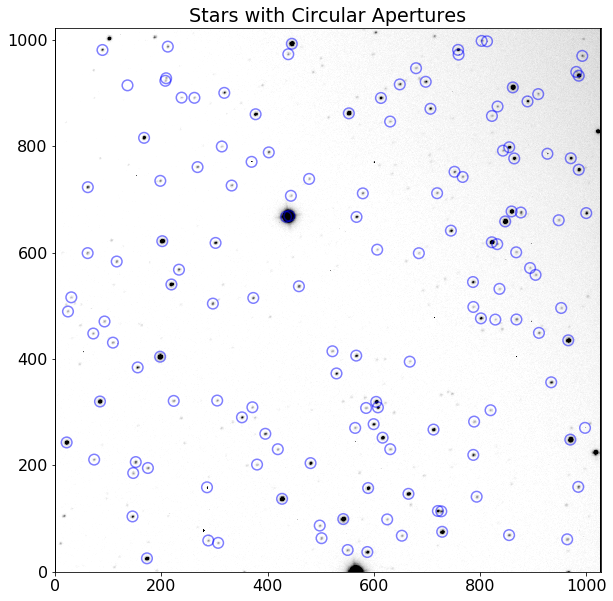

In [27]:
#Plotting stars with circles (apertures)
plt.figure(figsize=(10, 10))
plt.rcParams['font.size'] = 16

plt.title('Stars with Circular Apertures')
plt.imshow(image, cmap='gray_r', origin='lower', vmin = 0, vmax = 1000)
apertures.plot(color='blue', lw=1.5, alpha=0.5)


In [19]:
#Creating an annulus aperture    
apertures1 = CircularAnnulus(positions, r_in = 8., r_out = 10.)    
phot_table1 = aperture_photometry(image, apertures1)    
phot_table1

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,172.86662561407712,24.843851416988482,889.2650417922399
2,587.5937806506138,36.75153696032994,2264.1306990285348
3,550.5956282416972,40.522206397186935,1692.0294232601746
4,306.8402462567255,53.96426698034937,-323.4512870991156
5,288.2562703963834,58.44526849941758,1053.0407815965439
6,963.7108047715628,60.640378436930526,1619.3079024264566
7,501.4401539740751,62.75535355996978,163.4671581299641
8,652.5349354348033,67.41482896188127,150.2209337414219


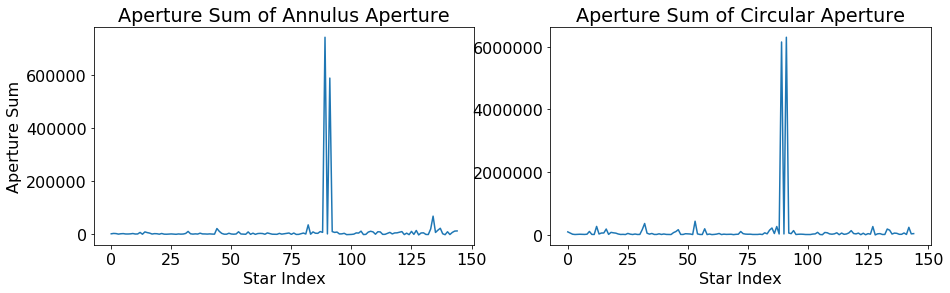

In [30]:
#Comparing the different apertures
fig,ax = plt.subplots(1,2)                  
fig.set_size_inches(15,4)


ax[0].set_title('Aperture Sum of Annulus Aperture')
ax[0].set_ylabel('Aperture Sum')
ax[0].set_xlabel('Star Index')
ax[0].plot(phot_table1['aperture_sum'])

ax[1].set_title('Aperture Sum of Circular Aperture')
ax[1].set_xlabel('Star Index')
ax[1].plot(phot_table['aperture_sum']);

## PSF Fitting

In [35]:
#create an IterativelySubtractedPSFPhotometry object
sigma_psf = 2.0
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

my_photometry = IterativelySubtractedPSFPhotometry(finder=daofind, group_maker=daogroup,
                bkg_estimator=mmm_bkg, psf_model=psf_model,
                 fitter=LevMarLSQFitter(), niters=3, fitshape=(7,7))

# get photometry results
photometry_results = my_photometry(image=image)
# get residual image
residual_image = my_photometry.get_residual_image()
photometry_results

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int32
561.2974457616049,561.2454670523639,1.056061872952148,0.7719114533161084,2099342.83544371,1780000.6102333923,1,1,151026.4004303388,0.2661864614522623,0.2977626108301236,1
565.1097789679757,565.5813756543117,4.110159006303765,3.330689235388719,2831469.814544705,2090797.8911238492,3,1,138073.9787369481,0.21509899152144385,0.18465972133225686,1
1025.513372487733,1027.5979833821664,1.5341931266613915,2.482393814001534,388271.84712499223,1412225.051030971,2,2,527282.5585111153,0.7427739612570052,0.3316608227574816,1
172.86662561407712,172.86186133410013,24.843851416988482,24.816113574885076,80182.06082238618,87934.26341843698,4,3,1258.3933234172189,0.0429537616899161,0.04298864055600153,1
587.5937806506138,587.6039969465692,36.75153696032995,36.691135347403794,44649.45874377097,47605.90231348545,5,4,605.4220703202798,0.038345721252834336,0.038299535819500005,1
550.5956282416972,550.604446321865,40.522206397186935,40.46178138413785,12121.832921961908,12615.051510000718,6,5,175.69352709521567,0.04197349461591103,0.04228941926917935,1
10.529920087487517,10.489009983622722,53.14372901008192,53.188764526487695,6877.392336824527,7890.196590043238,7,6,166.9704280668686,0.06418585224909257,0.06353670538173235,1
306.8402462567255,306.8881476295107,53.96426698034937,53.92248338462933,8201.968712410542,8978.640276084374,8,7,145.1960226447635,0.0485260080767423,0.04852034033384807,1
288.2562703963834,288.2032653564376,58.44526849941758,58.47724629196605,9273.99686979937,10068.400467268064,9,8,149.33221264369809,0.04456032796837517,0.04492721857820169,1


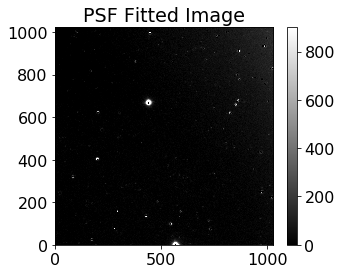

In [46]:
plt.title("PSF Fitted Image")
plt.imshow(my_photometry.get_residual_image(), cmap = 'gray',origin='lower', vmin = 0, vmax=900) 
plt.colorbar(orientation='vertical', fraction=0.046, pad=0.04);

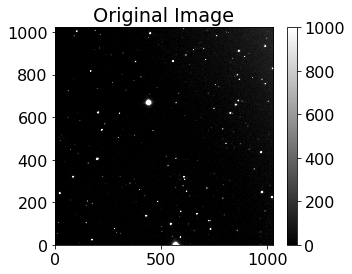

In [38]:
plt.title("Original Image")
plt.imshow(image, cmap='gray', origin='lower', vmin = 0, vmax = 1000)
plt.colorbar(orientation='vertical', fraction=0.046, pad=0.04);

## Comparing Aperture to PSF Fitting

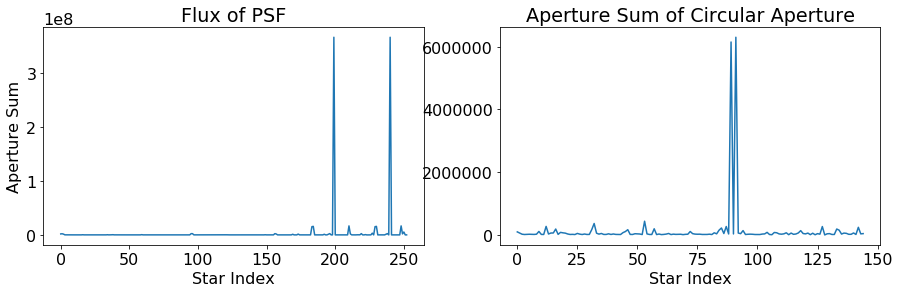

In [40]:
#Comparing Aperture to PSF Fitting
fig,ax = plt.subplots(1,2)                  
fig.set_size_inches(15,4)


ax[0].set_title('Flux of PSF')
ax[0].set_ylabel('Aperture Sum')
ax[0].set_xlabel('Star Index')
ax[0].plot(photometry_results['flux_fit'])

ax[1].set_title('Aperture Sum of Circular Aperture')
ax[1].set_xlabel('Star Index')
ax[1].plot(phot_table['aperture_sum']);